In [39]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
!pip install open3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
%cd /content/drive/MyDrive/ModelNet10

#changing the working directory to the folder where the dataset is located

[Errno 2] No such file or directory: '/content/drive/MyDrive/ModelNet10'
/content


In [42]:
!pip install trimesh
!pip install rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
import os
import torch
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import trimesh
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d

In [44]:
class ModelNet10Dataset(Dataset):
    def __init__(self, root_dir, kind, transform=None): #root_dir is the root directory where the files are located
        self.root_dir = root_dir
        self.transform = transform #optional parameters that specifies a transformation to be applied in the dataset samples
        self.mesh_files = [] #empty list to store the content of each file
        self.labels = [] #empty list to store the labels of each file
        self.class_names = sorted(os.listdir(self.root_dir)) #tuple of names of the possible classes
        for i, class_name in enumerate(self.class_names): #iterate through the possible classes
            class_dir = os.path.join(self.root_dir, class_name) #get the directory of the folder by merging
            class_dir_train = os.path.join(class_dir, kind)
            for mesh_file in os.listdir(class_dir_train): #iterating through each file
                self.mesh_files.append(os.path.join(class_dir_train, mesh_file)) #append the class directory and the file
                self.labels.append(i)

    def __len__(self):
        return len(self.mesh_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        mesh_file = self.mesh_files[idx]
        label = self.labels[idx]
        mesh = trimesh.load(mesh_file)

        if self.transform:
            mesh = self.transform(mesh)
        return mesh, label, self.class_names[label]


#this is the way of deploying the dataset thaught by te professor in lab 02.
#we define an object that inherits from Dataset class, so it already starts with its funtionalities
#first we initialized the class
#then we define a method that returns the dataset legth
#then we define a method that allow us to pick up one element by index, and we add a transformation as a conditional

In [45]:
training_set = ModelNet10Dataset('/content/drive/MyDrive/Voxel_Grid_classifier/Data/ModelNet10', kind="train", transform=None)
#training set initialized with no transformation applied
#the parameter kind is used to deploy either the training set, by "train", or the testing set "test", following the name of the folders in the modelnet10 dataset

In [46]:
index=801

mesht, label, name = training_set[index]

vertices=mesht.vertices #3D coordinates
faces=mesht.faces #3D coordinates


sample=trimesh.Trimesh(vertices=vertices, faces=faces, process=False)
sample.show()


#this cell is used to visualize one of the samples on CAD format



##Explanation on the CAD to Point Cloud Transformation

To make a point cloud representation out of the cad format, one idea is to generate random points inside the surfaces defined by the triangles vertices, in order to complete the scatter plot produced by only the vertices. That`s what the function points_in_triangle above does.

triangle_area is used to calculate the area of the triangles that we have, because its reasonable that we should keep a constant density to generate points across our object, so the bigger the area of one triangle is, the more points will be generated inside.


This is a nice point cloud representation of the object. The next step is either to broadcast every sample in a standardized size grid and then convert to voxel grid or try to convert it directly to Voxel Grid, skipping the broadcasting step.

Lets take a look at some samples to have an idea of what should be the size of our grid and its boxes.

In [47]:
from numpy import random

In [48]:

import torchvision.transforms as transforms

class Mesh:
    def __init__(self, vertices, faces):
        self.vertices = vertices
        self.faces = faces

class ToMesh:
    def __call__(self, mesh):
        vertices = np.asarray(mesh.vertices, dtype=np.float32)
        faces = np.asarray(mesh.faces, dtype=np.float32)
        return Mesh(vertices, faces)

def triangle_area(point1, point2, point3):
    return 0.5 * np.linalg.norm(np.cross(point2 - point1, point3 - point1)) #calculate the area of a triangle given its vertices

def points_in_triangle(point1, point2, point3, num_points): #generate random points within a triangle
    u = np.random.uniform(0, 1, num_points)
    v = np.random.uniform(0, 1, num_points)
    is_inside = (u + v <= 1)
    u_inside = u[is_inside]
    v_inside = v[is_inside]
    w_inside = 1 - u_inside - v_inside
    points = (u_inside[:, None] * point1) + (v_inside[:, None] * point2) + (w_inside[:, None] * point3)
    return points

class PointCloud:
    def __init__(self, faces=None, vertices=None, density=10):
        self.faces = faces
        self.vertices = vertices
        self.density=density

    def generate_new_points(self, density, smallest=0.02):
        new = np.empty((0, 3))
        for i in range(len(self.faces)):
            point1 = self.vertices[int(self.faces[i][0])]
            point2 = self.vertices[int(self.faces[i][1])]
            point3 = self.vertices[int(self.faces[i][2])]

            area = triangle_area(point1, point2, point3)
            if area > smallest:
                number_of_points = int(density * area)
                new_points = points_in_triangle(point1, point2, point3, number_of_points)
                new = np.concatenate((new, new_points))

        return Mesh(np.concatenate((self.vertices, new)), self.vertices)

    def __call__(self, mesh):
        self.faces = mesh.faces
        self.vertices = mesh.vertices
        return self.generate_new_points(self.density)

class Rescale:
    def __init__(self, size, scaling_param=1.1):
        self.size = size
        self.scaling_param=scaling_param

    def __call__(self, mesh):
        rescaled = mesh.vertices * (int(self.size) / 2) / (self.scaling_param * np.max(mesh.vertices))
        return Mesh(rescaled, None)

class Broadcast:
    def __init__ (self):
      pass
    def __call__ (self,mesh):
        voxel_points = mesh.vertices.astype(int) #broadcast the elements simpling truncating to the closest integer
        return Mesh(voxel_points, None)

class Unique:
    def __init__(self, minimum_count=2):
      self.minimum_count = minimum_count
    def __call__(self, mesh):
        flattened_array = mesh.vertices.view(np.dtype((np.void, mesh.vertices.dtype.itemsize * mesh.vertices.shape[1])))  #flatten the original array to 1D
        unique_elements, counts = np.unique(flattened_array, return_counts=True) # get unique elements and their counts
        selected_elements = unique_elements[counts >= self.minimum_count ] # select the elements with a frequency greater than or equal to min_frequency
        selected_arrays = np.array([np.frombuffer(element, dtype=mesh.vertices.dtype) for element in selected_elements]) # Convert the selected elements back to arrays

        return Mesh(selected_arrays, None)

class GenerateVoxelGrid:
    def __init__(self, size):
        self.size = size

    def __call__(self, mesh):
        offset_data=mesh.vertices+self.size/2 #offset to have everything positive
        final_grid = np.zeros((self.size, self.size, self.size))
        for i in range(len(offset_data)):
          final_grid[int(offset_data[i][0]),int(offset_data[i][1]), int(offset_data[i][2])]=1  #fulfill final grid with the data obteined before
        return Mesh(final_grid, None)


In [49]:
#we can also get a point cloud representation composing the transformation only until PointCloud

# let`s define the composition of transformations
ToPointCloud = transforms.Compose([
    ToMesh(),
    PointCloud()
    #Rescale(size=20),
    #Broadcast(),
    #Unique(),
    #GenerateVoxelGrid()
])

training_set_pc = ModelNet10Dataset('/content/drive/MyDrive/Voxel_Grid_classifier/Data/ModelNet10', kind="train", transform=ToPointCloud)
sample, label, name = training_set_pc[index]

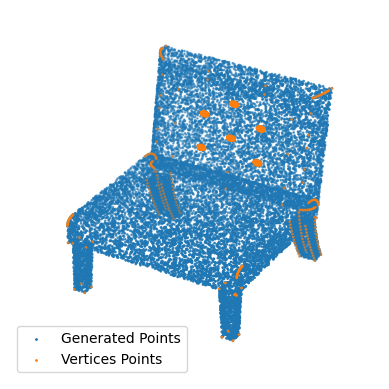

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x, y, z = sample.vertices.transpose()
xf, yf, zf = sample.faces.transpose()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Create a 3D scatter plot
ax.scatter(x, y, z, label="Generated Points", s=1)  # Scatter plot for generated points
ax.scatter(xf, yf, zf, label="Vertices Points", s=1)  # Scatter plot for vertices points

ax.set_box_aspect([1, 1, 1])  # Preserve aspect ratio of axes
ax.grid(False)  # Remove the grid
ax.axis('off')  # Remove the axes
ax.set_title('')  # Set an empty title
ax.legend()

plt.show()


In [51]:
# And now we continue the pipeline of transformations untill the voxel grid format
def final_data(density=30, scaling_param=1.02, size=150, minimum_count=1):

  #density: set the density of the point_cloud (float)
  #scaling_param: scaling parameter, must be greater that 1 to make the object fit in the box, but not that much
  #size: set the size of the box (must be integer, for simplicity)
  #minimum_count: this parameter can exclude boxes that have less points than a certain number, must be an integer

  ToVoxel = transforms.Compose([
      ToMesh(),
      PointCloud(density),
      Rescale(size=size, scaling_param=scaling_param),
      Broadcast(),
      Unique(minimum_count),
      GenerateVoxelGrid(size)
  ])
  return ToVoxel



training_set_vg = ModelNet10Dataset('/content/drive/MyDrive/Voxel_Grid_classifier/Data/ModelNet10', kind="train", transform=final_data())

datavg, label, name=training_set_vg[index]

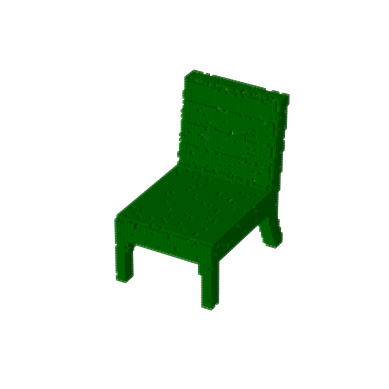

In [52]:
# try diferent simpler parameters and count the time the task takes
training_set_vg = ModelNet10Dataset('/content/drive/MyDrive/Voxel_Grid_classifier/Data/ModelNet10', kind="train", transform=final_data(density=10, size=60))


datavg, label, name=training_set_vg[index]

#create a figure and an Axes3D subplot
arr_data=datavg.vertices
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Iterate over each voxel
for layer in range(arr_data.shape[0]):
    for row in range(arr_data.shape[1]):
        for col in range(arr_data.shape[2]):
            if arr_data[layer, row, col] != 0:
                ax.bar3d(layer, row, col, 1, 1, 1, color='g', alpha=0.5)# If the voxel value is non-zero lot a voxel at the corresponding coordinates


ax.set_xlim([0, arr_data.shape[2]])
ax.set_ylim([0, arr_data.shape[1]])
ax.set_zlim([0, arr_data.shape[0]])
ax.set_axis_off()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.grid(False)


plt.show()